# Perceptron Learning Algorithm (Binary Classifier)

### Modification History
\>\>\> ZJ Zhang (Jan 23th, 2017) 

## 1. Overview
Given $N$ input vectors with $D$ dimensions as training data, with each noted as $\boldsymbol{x_{i}}$ and known labels of $l_{i}$ (binary values of $-1$ or $1$), I will build a perceptron that the output of each $\boldsymbol{x_{i}}$ is exactly its corresponding label of $l_{i}$. Each vector $\boldsymbol{x_{i}}$ could be expressed as

$$
\boldsymbol{x_{i}} = (x_{i,1}, x_{i,2}, ..., x_{i,D})
$$
with each element termed $x_{i,j}$ ($j=1,2,...,D$)

In [1]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Formating 
matplotlib.rcParams['axes.linewidth'] = 2
_ = np.seterr(divide='ignore', invalid='ignore')

## 2. Training Data
Training data are created by prior knowledge. I assume there are $N$ vectors (or points) serving as training data, randomly distributed within a $D$-dimensional sphere with a radius of $R$. Then I assign them labels based on a linear boundary, described by 
$$
p_{0} + p_{1}x_{1} + p_{2}x_{2} + ... + p_{D}x_{D} = 0 \quad \Rightarrow \quad \boldsymbol{m_{j}}\boldsymbol{x_{j}}=0
$$
where,
$$
\begin{align}
\boldsymbol{p} &= (p_{0}, p_{1}, p_{2}, ..., p_{D}) \\
\boldsymbol{x} &= (1, x_{1}, x_{2}, ..., x_{D})
\end{align}
$$
**If an vector point is above the boundary, then I assign a label of $1$, otherwise (i.e., below or right on the boundary), I assign a label of $-1$.**

Here I assume all data are uniformly distributed in the hypersphere. In addition, the boundary parameters $\boldsymbol{p}$ are generated randomly within $[p_{\rm min}, p_{\rm max}]$ with a dimension of $D+1$. The following parameters are defiend by the user: $N$, $D$, $R$, $p_{\rm bound} = [p_{\rm min}, p_{\rm max}]$. 

In [2]:
## metric of the training data - defined by the user
Nd = 100 # number of vectors/points
Dd = 2   # dimension
Rd = 100  # radius of the hypersphere where all data are distributed
p_bound = [-10, 10]  # extent of the boundary parameters

# generate the prior boundary parameter p
p_param = np.random.uniform(low=p_bound[0], high=p_bound[-1], size=Dd+1)

In [3]:
## training data generation
Train_Data = np.random.uniform(low=-Rd, high=Rd, size=(Nd,Dd+1))
Train_Data[:,0] = 1.0  # append a 1.0 to the beginning of each vectors' coordinates
# assign labels based on points' position compared to the prior boundary
Train_boolLabel = np.sum(Train_Data*p_param, axis=1) > 0  # points located above the boundary have "True" with remaining have "False"
Train_Label = np.array(2 * Train_boolLabel - 1)  # convert "True" and "False" to "1" and "-1", respectively

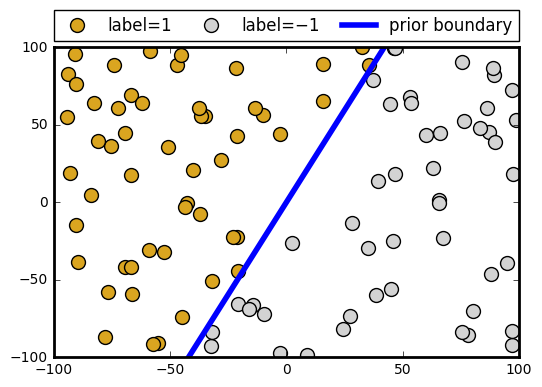

In [4]:
## plot the training data and the prior boundary - for 2D only
if Dd==2:
    # marker geometry
    marker = 'o'
    markersize = 10
    markeredgewidth = 1
    # colors
    pos_color = 'goldenrod'
    neg_color = 'lightgrey'
    edgecolor = 'k'
    # lines
    marker_linestyle = 'None'
    bound_linestyle = '-'
    bound_linewdith = 4
    prbound_color = 'blue'
    # plot points with different labels
    pos_id = np.where(Train_Label==1)[0]
    plt.plot(Train_Data[pos_id,1], Train_Data[pos_id,2], marker=marker, 
             markersize=markersize, markerfacecolor=pos_color, markeredgecolor=edgecolor, 
             markeredgewidth=markeredgewidth, linestyle=marker_linestyle, label='label=1')
    neg_id = np.where(Train_Label==-1)[0]
    plt.plot(Train_Data[neg_id,1], Train_Data[neg_id,2], marker=marker, 
             markersize=markersize, markerfacecolor=neg_color, markeredgecolor=edgecolor, 
             markeredgewidth=markeredgewidth, linestyle=marker_linestyle, label=u'label=\u22121')
    # plot the prior boundary
    x_bound = np.linspace(-Rd, Rd,2)
    y_prbound = -1.0 * (p_param[0] + p_param[1]*x_bound) / p_param[2]
    plt.plot(x_bound, y_prbound, color=prbound_color, linestyle=bound_linestyle, 
             linewidth=bound_linewdith, label='prior boundary')
    # limits and label
    plt.xlim([-Rd, Rd])
    plt.ylim([-Rd, Rd])
    # legend
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, numpoints=1, mode="expand", borderaxespad=0.)

## 3. Algorithm
The perceptron learning is actually to find the (linear) boundary that separate the vectors/points with two labels, given the training data. The whole algorithm include the following steps:

1) Initialize a boundary parameter $\boldsymbol{w}$, weights.

2) For misclassified examples (e.g., $\boldsymbol{x_{j}}$ whose $l_{j} \neq y_{j}$), compute the classifier output ($y_{j}$) and update the weights based on $\boldsymbol{w} += c (l_{j} - y_{j}) \boldsymbol{x_{j}}$, where $c$ is the learning rate.

3) Iterate among all of the training data until the output classification of all data match their own labels.

If the training data are linearly spearable, then the perceptron will converge and provide the boundary parameters. Otherwise, the perceptron will endlessly iterate without termination. In order to define if the iteration is endless or not, we use the tolerant iteration number of 
$$
N_{\rm iter,tol} = 10^{2} \times N_{d}
$$
**In other words, if the effective iteration times (the iterations that update the boundary parameters $\boldsymbol{w}$) exceeds the tolerant iteration numbers, then we call it unconvergent, and the data are thereby not linearly separable.**

In [5]:
## tolerant iteration number
N_tol_iter = 10**3 * Nd

### 3.1 Algorithm Implementation

In [6]:
## Build a perceptron
def perceptron(Train_Data, Train_Label, learn_rate=np.pi, N_failstep=100, w_param_init=None, conv=False):
    ''' Given training data, return the perceptrons that predict their binary classifications
    
    >>> Input:
    - training data and labels
    - learning rate:
        the "normalized" step size every time the boundary parameter is updated
        [default = pi]
    - N_failstep:
        if the training data are not linearly separable, then return the first N_failtstep of the boundary 
    parameters during iterations
        [default = 100]
    - w_param_init:
        initial boundary parameter. If None, then the program will generate for the user.
        [default = None]
    - conv:
        prior knowledge about the convergence of training data. 
        If True, then the perceptron will iterate until an ideal boundary is found.
        If False or None, then the perceptron will claim that the training data are not convergent after 
    a certain amount of iterations (defined by N_tol_iter)
        [default = False]

    >>> Output
    - w_param_steps: 
        record all parameter boundaries during iterations
    - N_iter:
        The total number of iterations
    '''
    # initialize the boundary parameter
    if w_param_init is None:
        w_param = np.random.uniform(low=p_bound[0], high=p_bound[-1], size=Dd+1)
    else:
        w_param = 1.0 * w_param_init + 0.0
    # save w_param at each iteration step
    w_param_steps = 1.0 * w_param + 0.0 
    # success number
    success_num = 0
    # total iteration times
    N_iter = 0
    # index of scanning the training data
    index_data = 0
    while success_num<Nd:
        # decide if the current data has correct model-predicted label
        Model_boolLabel_cur = np.sum(Train_Data[index_data] * w_param) > 0
        Model_Label_cur = 2 * Model_boolLabel_cur - 1
        if Model_Label_cur == Train_Label[index_data]:
            success_num += 1
        else:
            success_num = 0
            w_param += learn_rate * (Train_Label[index_data] - Model_Label_cur) * Train_Data[index_data]
            w_param_steps = np.vstack((w_param_steps, w_param))
        index_data = (index_data+1)%Nd
        N_iter += 1
        # check if the perceptron convergents
        if (conv is not True) and (len(w_param_steps) >= N_tol_iter):
            print("(ZJ-Style) Error: Perceptrons cannot convergent - data are not linearly separable...")
            return w_param_steps[:N_failstep], N_iter
    return w_param_steps, N_iter
# --

### 3.2 Model outputs

In [7]:
## run the perceptron for training data
w_param_steps, _ = perceptron(Train_Data, Train_Label, conv=True)

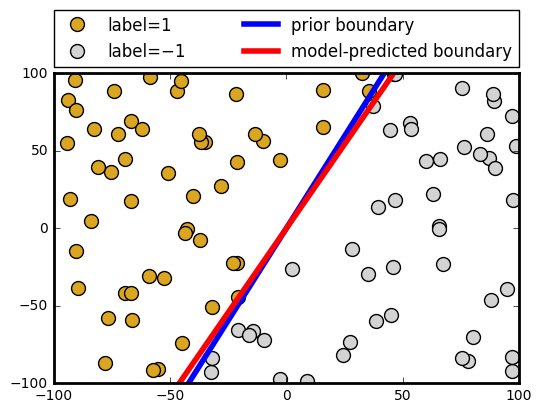

In [8]:
## compare the model-predicted boundary with the prior boundary - for 2D only
if Dd==2:
    compbound_color = 'red'
    # plot points with different labels
    plt.plot(Train_Data[pos_id,1], Train_Data[pos_id,2], marker=marker, 
             markersize=markersize, markerfacecolor=pos_color, markeredgecolor=edgecolor, 
             markeredgewidth=markeredgewidth, linestyle=marker_linestyle, label='label=1')
    plt.plot(Train_Data[neg_id,1], Train_Data[neg_id,2], marker=marker, 
             markersize=markersize, markerfacecolor=neg_color, markeredgecolor=edgecolor, 
             markeredgewidth=markeredgewidth, linestyle=marker_linestyle, label=u'label=\u22121')
    # plot the prior boundary
    y_prbound = -1.0 * (p_param[0] + p_param[1]*x_bound) / p_param[2]
    plt.plot(x_bound, y_prbound, color=prbound_color, linestyle=bound_linestyle, 
             linewidth=bound_linewdith, label='prior boundary')
    # plot the model-predicted boundary
    y_compbound = -1.0 * (w_param_steps[-1][0] + w_param_steps[-1][1]*x_bound) / w_param_steps[-1][2]
    plt.plot(x_bound, y_compbound, color=compbound_color, linestyle=bound_linestyle, 
             linewidth=bound_linewdith, label='model-predicted boundary')
    # limits and label
    plt.xlim([-Rd, Rd])
    plt.ylim([-Rd, Rd])
    # legend
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, numpoints=1, mode="expand", borderaxespad=0.)

### 3.3 Convergence Movie
Define a function to plot a movie of the model-predicted boundaries as a function of iterations.

In [9]:
## movie for all the boundary parameter
def modelbound_movie(Train_Data, Train_Label, w_param_steps, movie_path='./perceptron_conv.mp4'):
    ''' generate a movie given the training data and the model-predicted boudnary at each iteration step'''
    # figure set up
    figure, ax = plt.subplots(figsize=(10,8)) 
    # marker geometry
    marker = 'o'
    markersize = 10
    markeredgewidth = 1
    # colors
    pos_color = 'goldenrod'
    neg_color = 'lightgrey'
    edgecolor = 'k'
    # lines
    marker_linestyle = 'None'
    bound_linestyle = '-'
    bound_linewdith = 4
    prbound_color = 'blue'
    # plot points with different labels
    pos_id = np.where(Train_Label==1)[0]
    plt.plot(Train_Data[pos_id,1], Train_Data[pos_id,2], marker=marker, 
             markersize=markersize, markerfacecolor=pos_color, markeredgecolor=edgecolor, 
             markeredgewidth=markeredgewidth, linestyle=marker_linestyle, label='label=1')
    neg_id = np.where(Train_Label==-1)[0]
    plt.plot(Train_Data[neg_id,1], Train_Data[neg_id,2], marker=marker, 
             markersize=markersize, markerfacecolor=neg_color, markeredgecolor=edgecolor, 
             markeredgewidth=markeredgewidth, linestyle=marker_linestyle, label=u'label=\u22121')
    # plot the prior boundary
    x_bound = np.linspace(-Rd, Rd,2)
    y_prbound = -1.0 * (p_param[0] + p_param[1]*x_bound) / p_param[2]
    plt.plot(x_bound, y_prbound, color=prbound_color, linestyle=bound_linestyle, 
             linewidth=bound_linewdith, label='prior boundary')
    # plot the model-output boundary at each time
    pltmodel_list = []
    N_eff_iter = len(w_param_steps)
    for index_frame in range(0,N_eff_iter):
        y_bound_step = -1.0 * (w_param_steps[index_frame][0] + 
                               w_param_steps[index_frame][1]*x_bound) / w_param_steps[index_frame][2]
        plt_modelbound = plt.plot(x_bound, y_bound_step, color=compbound_color, linestyle=bound_linestyle, 
                                  linewidth=bound_linewdith)
        pltmodel_list.append(plt_modelbound)
    # limits and label
    plt.xlim([-Rd, Rd])
    plt.ylim([-Rd, Rd])
    # legend
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, numpoints=1, 
               mode="expand", borderaxespad=0.,fontsize=18)
    # title
    plt.title('Convergence with %d effective iterations'%(N_eff_iter), y=-0.1, fontsize=20)
    
    # start animation
    movie = animation.ArtistAnimation(figure, pltmodel_list, interval=200, blit=True, repeat_delay=1000)
    movie.save(movie_path)
    return movie
# --

Here I show the movie for the above model predictions.

In [10]:
movie = (modelbound_movie(Train_Data, Train_Label, w_param_steps, movie_path='./perceptron_conv.mp4'))
plt.close()  # prevent showing the figure by calling "movie", I'd like to show a movie using the following line
HTML(movie.to_html5_video())

## 4. Investigations
Here I investigate the following few points about the performance of perceptrons.

### 4.1 Perceptron performance with the XOR training data
In order to investigate if perceptrons are able to handle the training data that are not linearly separable, I revise the pre-defined labels for training data and rerun the perceptron models. As a quick revision, I keep the total number of points with $1$ and $-1$ labels, respectively, but change the orders of their labels. 

In [ ]:
## Revisions of training labels
# find number of "1" label points
num_pos = len(pos_id)
Train_Label_XOR = np.ones_like(Train_Label) * np.nan
Train_Label_XOR[:num_pos] = 1
Train_Label_XOR[num_pos:] = -1

In [ ]:
## run perceptrons for the revised training data
w_param_XORsteps, _ = perceptron(Train_Data, Train_Label_XOR, conv=False)
## show the movie 
movie_XOR = modelbound_movie(Train_Data, Train_Label_XOR, w_param_XORsteps, movie_path='./perceptron_NOTconv.mp4')
plt.close()  # prevent showing the figure by calling "movie", I'd like to show a movie using the following line
HTML(movie_XOR.to_html5_video())

### 4.2 The maximum interation number $N_{\rm iter,max}$ as a function of learning rate $R_{\rm learn}$
I use different $R_{\rm learn}$ with the same randomly initialized boundary parameter $\boldsymbol{w}$. I record the maximum iteration number $N_{\rm iter,max}$ for each $R_{\rm learn}$ that are needed for model training. Also, in order to investigate the impact of the initialized boundary parameter $\boldsymbol{w}$ on the final $N_{\rm iter,max}$ vs. $R_{\rm learn}$ curve, I initialize the boundary parameter several times $N_{\rm init}$ to create many ensembles.

In [41]:
# Here I build up the perceptron again, by including more components
### Basic settings
# number of initializations of the boundary parameters
N_init = 10000
# list of learning rates
Rlearn_bound = [-4,2]
Rlearn_num = 20
Rlearn = 10**(np.linspace(Rlearn_bound[0], Rlearn_bound[-1], Rlearn_num))
# empty arrays to save the maximum iterations and the final weights
MaxNiter = np.ones((N_init, Rlearn_num)) * np.nan
Weights = np.ones((N_init, Rlearn_num, Dd+1)) * np.nan
### Start each ensemble
for index_init in range(0,N_init):
    # initialize the boundary parameter
    w_param_init = np.random.uniform(low=p_bound[0], high=p_bound[-1], size=Dd+1)
    # scan each learning rate
    for index_learn in range(0,Rlearn_num):
        w_param_steps, N_iter = perceptron(Train_Data, Train_Label, 
                                               learn_rate=Rlearn[index_learn], w_param_init=w_param_init, conv=False)
        MaxNiter[index_init, index_learn] = N_iter
        Weights[index_init, index_learn] = w_param_steps[-1]

KeyboardInterrupt: 

Here I plot the $N_{\rm iter,max}$ as a function of $R_{\rm learn}$, with different initialized boundary parameter $\boldsymbol{w}$ (*black*). For simplicity, I normalize the $N_{\rm iter,max}$ as
$$
\frac{N_{\rm iter,max} - N_{\rm d}}{N_{\rm d}}
$$
I subtract $N_{\rm d}$ from $N_{\rm iter,max}$ because the first $N_{\rm iter,max}$ iterations are mandatory for all sets of data. Or put it in other words, the model need to scan through each data point to check if it could give a correct label.

Also, I derive the median $N_{\rm iter,max}$ among all of the given learning rates (*red*). It is clear that there might be an optimal learning rate, which could give us statistically the smallest number of iterations. The optimal learning rate is ~$4\times10^{-2}$ **with the given metric of the training data**.

The optimal learning rate is around 7e-02


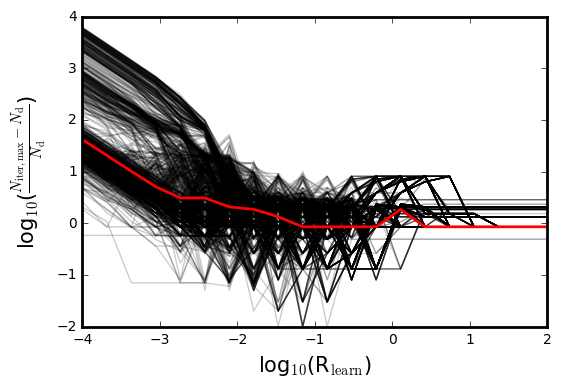

In [40]:
# plot the N_iter_max vs. R_learn for each ensemble
for index_init in range(0,N_init):
    plt.plot(np.log10(Rlearn), np.log10((MaxNiter[index_init]-Nd)/Nd), linewidth=1, color='k', alpha=0.2)
    plt.xlabel(r'log$_{10}$(R$_{\rm learn}$)',fontsize=15)
    plt.ylabel(r'log$_{10}$($\frac{N_{\rm iter,max} - N_{\rm d}}{N_{\rm d}}$)',fontsize=15)
# plot the mean Maximum interation number among all ensembles
Mean_MaxNiter = np.median(MaxNiter, axis=0)
plt.plot(np.log10(Rlearn), np.log10((Mean_MaxNiter-Nd)/Nd), linewidth=2, color='red', alpha=1)

# find the optimal learning rate
print("The optimal learning rate is around %.0e"%(Rlearn[np.argmin(Mean_MaxNiter)]))